# Natural Language Processing Final Project
This project is a sentiment analysis on Youtube video comments <br> The dataset is from Kaggle https://www.kaggle.com/adepvenugopal/sentiment-analysis-of-youtube-comments/data <br> This is strictly for educational purposes

## Author <br>
1. Rayhan Faris
2. Rayyan

### References
* https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15
* https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1
* https://medium.com/@annabiancajones/sentiment-analysis-on-reviews-train-test-split-bootstrapping-cross-validation-word-clouds-4ae65e745f59
* https://github.com/kb22/Twitter-Sentiment-Analysis/blob/master/train-test-split.py
* https://github.com/KwokHing/SentimentAnalysis-Python-Demo/blob/master/SentimentAnalysis.ipynb

Date: 30 November 2021


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import necessary libraries

In [ ]:
!pip install vaderSentiment

import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Read data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab/Youtube Dataset/UScomments.csv', 
                 error_bad_lines=False)
df.head(5)

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691400 entries, 0 to 691399
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   video_id      691400 non-null  object
 1   comment_text  691375 non-null  object
 2   likes         691400 non-null  object
 3   replies       691400 non-null  object
dtypes: object(4)
memory usage: 21.1+ MB


In [ ]:
df = df.drop(['likes', 'replies'], axis=1)
df

,video_id,comment_text
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️
1,XpVt6Z1Gjjo,I've been following you from the start of your...
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me
3,XpVt6Z1Gjjo,MY FAN . attendance
4,XpVt6Z1Gjjo,trending 😉
...,...,...
691395,EoejGgUNmVU,Лучшая
691396,EoejGgUNmVU,qu'est ce que j'aimerais que tu viennes à Roan...
691397,EoejGgUNmVU,Ven a mexico! 😍 te amo LP
691398,EoejGgUNmVU,Islığı yeter...


In [ ]:
df.groupby('video_id')['comment_text'].count().sort_values(ascending=False)

video_id
Hlt3rA-oDao    800
CYoRmfI0LUc    800
LunHybOKIjU    800
4X6a3G_0HjY    800
WYYvHb03Eog    800
              ... 
mi52IqpOp54      1
mShBE_wHAk8      1
jLa9wZHiqxg      1
HjfN2Phsfng      1
c5RsAXsZvI8      1
Name: comment_text, Length: 2266, dtype: int64

Remove Null & duplicate data

In [ ]:
before = df.shape[0]
print('Before dropping Null values and duplicates: {}'.format(df.shape))

df = df.dropna().drop_duplicates().reset_index(drop=True)
after = df.shape[0]

print('After: {}'.format(df.shape))
print('{} data were removed from the dataset'.format(before-after))

Before dropping Null values and duplicates: (691400, 2)
After: (450519, 2)
240881 data were removed from the dataset


In [ ]:
df.isnull().any()

video_id        False
comment_text    False
dtype: bool

# Labelling data
using vader sentiment score

In [ ]:
video_id = 'Hlt3rA-oDao' # LunHybOKIjU
df_first_video_comments = df[df['video_id'] == video_id].copy()

analyzer = SentimentIntensityAnalyzer()

# analyzer.polarity_scores('It\'s horribly a bad day')
sentiment = df_first_video_comments['comment_text'].apply(analyzer.polarity_scores)
sentiment = pd.DataFrame(sentiment.tolist())

df_first_video_comments.reset_index(drop=True, inplace=True)
sentiment.reset_index(drop=True, inplace=True)

df_sentiment = pd.concat([df_first_video_comments, sentiment], axis=1)
df_sentiment

,video_id,comment_text,neg,neu,pos,compound
0,Hlt3rA-oDao,"well now i can't sleep, thanks SNL.",0.253,0.526,0.221,-0.0788
1,Hlt3rA-oDao,She's looking sexy in this,0.000,0.541,0.459,0.5267
2,Hlt3rA-oDao,Why is this #2 on trending when it only have 1...,0.000,1.000,0.000,0.0000
3,Hlt3rA-oDao,how is this #2 on trending with only 13k views...,0.174,0.826,0.000,-0.5859
4,Hlt3rA-oDao,😂😂😂 Kate is trending on living legend status a...,0.158,0.526,0.316,0.8271
...,...,...,...,...,...,...
784,Hlt3rA-oDao,Can someone explain the Michigan and Wisconsin...,0.000,0.761,0.239,0.2960
785,Hlt3rA-oDao,Isn't that the same dyke cunt who played Hitlary?,0.254,0.556,0.190,-0.2023
786,Hlt3rA-oDao,But no one mentions how this is a big fear of ...,0.415,0.585,0.000,-0.7964
787,Hlt3rA-oDao,Hillary actually is just a shadow or illusion ...,0.188,0.812,0.000,-0.6249


In [ ]:
change_column_name = {'neg':'vader_negative',
                      'neu':'vader_neutral',
                      'pos':'vader_positive',
                      'compound':'vader_compound'}
print('before rename: ', df_sentiment.columns)

df_sentiment = df_sentiment.rename(columns=change_column_name)

print('before after: ', df_sentiment.columns)

before rename:  Index(['video_id', 'comment_text', 'neg', 'neu', 'pos', 'compound'], dtype='object')
before after:  Index(['video_id', 'comment_text', 'vader_negative', 'vader_neutral',
       'vader_positive', 'vader_compound'],
      dtype='object')


In [ ]:
df_sentiment['vader_sentiment_score'] = np.nan

for i in range(len(df_sentiment)):
  compound_score = df_sentiment.iloc[i, -2]

  if compound_score <= -0.05:
    df_sentiment.iloc[i,-1] = 'Negative'
  elif compound_score >= 0.05:
    df_sentiment.iloc[i,-1] = 'Positive'
  else:
    df_sentiment.iloc[i,-1] = 'Neutral'

df_sentiment.head()

,video_id,comment_text,vader_negative,vader_neutral,vader_positive,vader_compound,vader_sentiment_score
0,Hlt3rA-oDao,"well now i can't sleep, thanks SNL.",0.253,0.526,0.221,-0.0788,Negative
1,Hlt3rA-oDao,She's looking sexy in this,0.000,0.541,0.459,0.5267,Positive
2,Hlt3rA-oDao,Why is this #2 on trending when it only have 1...,0.000,1.000,0.000,0.0000,Neutral
3,Hlt3rA-oDao,how is this #2 on trending with only 13k views...,0.174,0.826,0.000,-0.5859,Negative
4,Hlt3rA-oDao,😂😂😂 Kate is trending on living legend status a...,0.158,0.526,0.316,0.8271,Positive


In [ ]:
df_sentiment.groupby(['vader_sentiment_score'])['comment_text'].count()

vader_sentiment_score
Negative    179
Neutral     202
Positive    408
Name: comment_text, dtype: int64

# Preprocessing
1. Remove Non-english words
2. Remove e-mails, extra spaces (\n\n)
3. Remove URL, hashtags
4. Remove duplicate symbols, video timestamps

In [ ]:
def cleanText(text):  
  english_stopwords = set(stopwords.words('english'))
  ps = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  text = text.lower()
  text = re.sub(r'\\n|\n', ' ', text) # \\n\nLook
  text = re.sub(r'\s*[!@#$%^&*()_+-={}|\[\]\:"\';\<>?,./‼️’]+(\s+)*', ' ', text) # punctuation
  text = re.sub(r'[^A-Za-z0-9 ]', ' ', text)  # emojis
  text = re.sub(r'\d+', ' ', text) # numbers
  text = re.sub(r'\s+(\W+)*', ' ', text)  # extra whitespace and all types of lines
  text = re.sub(r'https:\/\/\S+', ' ', text)  # links
  text = re.sub(r'at \d+:\d+', ' ', text) # video timestamps
  text = re.sub(r'\w\\n', ' ', text)  # single character
  text = re.sub(r'\s\w\s', ' ', text) # single character
  
  # Stemming and Lemmatization
  filtered_stemmed_text = [lemmatizer.lemmatize(ps.stem(w)) for w 
                           in word_tokenize(text) if w not 
                           in english_stopwords]

  text = TreebankWordDetokenizer().detokenize(filtered_stemmed_text)

  return text

In [ ]:
df_sentiment['cleaned_comment_text'] = df_sentiment['comment_text'].apply(cleanText)
df_sentiment = df_sentiment[['video_id', 'comment_text', 'cleaned_comment_text', 
                             'vader_negative', 'vader_neutral', 'vader_positive', 
                             'vader_compound', 'vader_sentiment_score']]

df_sentiment.head()

,video_id,comment_text,cleaned_comment_text,vader_negative,vader_neutral,vader_positive,vader_compound,vader_sentiment_score
0,Hlt3rA-oDao,"well now i can't sleep, thanks SNL.",well sleep thank snl,0.253,0.526,0.221,-0.0788,Negative
1,Hlt3rA-oDao,She's looking sexy in this,look sexi,0.000,0.541,0.459,0.5267,Positive
2,Hlt3rA-oDao,Why is this #2 on trending when it only have 1...,trend view,0.000,1.000,0.000,0.0000,Neutral
3,Hlt3rA-oDao,how is this #2 on trending with only 13k views...,trend view wtf anyon know orwellian algorithm ...,0.174,0.826,0.000,-0.5859,Negative
4,Hlt3rA-oDao,😂😂😂 Kate is trending on living legend status a...,kate trend live legend statu point,0.158,0.526,0.316,0.8271,Positive


# Visualization
Data exploration
1. positive, negative and neutral sentiment score distribution
2. most frequently used words in positive and negative statements

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


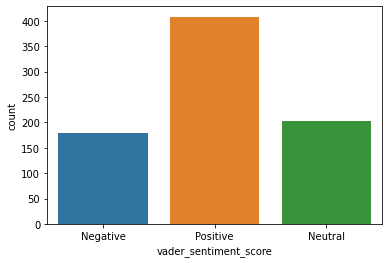

In [ ]:
sns.countplot('vader_sentiment_score', data=df_sentiment)

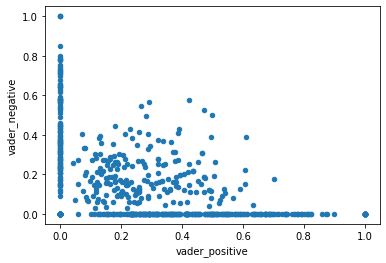

In [ ]:
df_sentiment.plot.scatter(x='vader_positive', y = 'vader_negative')

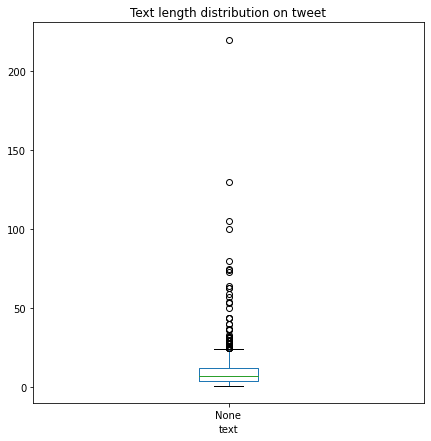

In [ ]:
tweet_len = pd.Series([len(tweet.split()) for tweet in df_sentiment['comment_text']])

plt.figure(figsize=(7,7))
plt.title('Text length distribution on tweet')
plt.xlabel('text')
tweet_len.plot(kind='box')

# Positive sentiment tweet analysis
1. Text length distribution
2. Most frequently used words on positive sentiment

In [ ]:
def tokenizeAllSent(df):
  english_stopwords = set(stopwords.words('english'))
  # flat = [x for sublist in nested for x in sublist]
  return [w for x in list(word_tokenize(w) for w in df) for w 
          in x if w not in english_stopwords]
  

count    408.000000
mean      11.232843
std       15.151396
min        1.000000
25%        4.000000
50%        8.000000
75%       13.000000
max      220.000000
dtype: float64


(array([367.,  32.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,  22.9,  44.8,  66.7,  88.6, 110.5, 132.4, 154.3, 176.2,
        198.1, 220. ]),
 <a list of 10 Patch objects>)

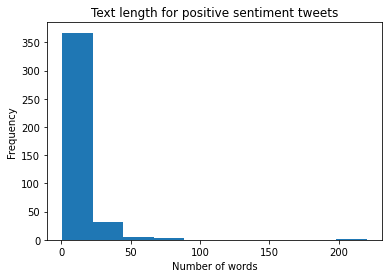

In [ ]:
positive_tweet_len = pd.Series([len(tweet.split()) for tweet 
                                in df_sentiment[df_sentiment['vader_sentiment_score'] == 'Positive']['comment_text']
                                if len(tweet.split()) > 0])

print(positive_tweet_len.describe())
plt.title("Text length for positive sentiment tweets")
plt.ylabel("Frequency")
plt.xlabel("Number of words")
plt.hist(positive_tweet_len)

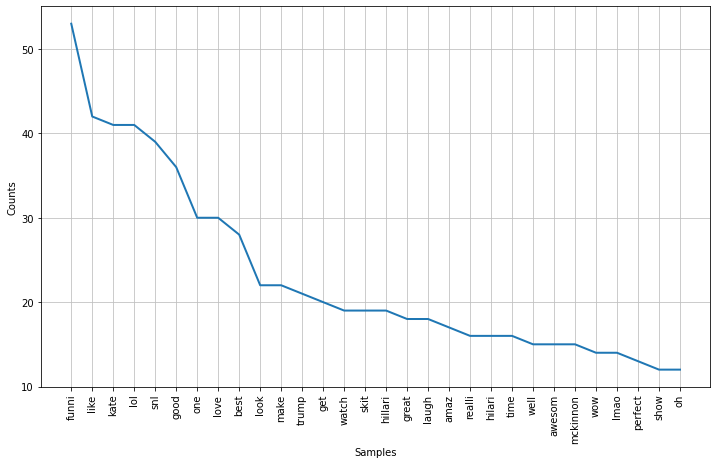

Displaying 25 of 53 matches:
 art got conway bit far last one saw funni one bit mean best becom mainstream g
ohn stewart colbert liber also talet funni knew object funni snl one thing make
t liber also talet funni knew object funni snl one thing make republican look b
republican look bad get alreadi noth funni show sinc sudeki left wow huge spoil
e awesom work snl suuuck none materi funni award individu skit would certainli 
omment section man good one snl fuck funni oh look kate win anoth emmi fuck awe
 impress point polit asid comed gold funni part kenan laugh hard okay puerto ri
er love love trump liber cock sucker funni love kate mckinnon much oml xd lmao 
hillari shitbag clinton though would funni use plot instead funni way look sexi
 though would funni use plot instead funni way look sexi dat make want quot giv
quinn maaaannnn snl use hilari stuff funni trump hilari imperson die non stop p
on die non stop polit show give dumb funni humor blooper one think better remak
d lmao wow 

In [ ]:
df_positive_tweets = df_sentiment[df_sentiment['vader_sentiment_score'] == 'Positive']['cleaned_comment_text']

tokenized_sent = tokenizeAllSent(df_positive_tweets)

fdist = nltk.FreqDist(tokenized_sent)
plt.figure(figsize=(12,7))
fdist.plot(30)
# fdist.most_common(30)

text = nltk.Text(tokenized_sent)
text.concordance('funni')

# Negative sentiment tweet analysis
1. Text length distribution
2. Most frequently used words on negative sentiment

count    179.000000
mean      13.184358
std       16.308631
min        1.000000
25%        5.000000
50%        9.000000
75%       15.000000
max      130.000000
dtype: float64


(array([121.,  44.,   8.,   1.,   1.,   1.,   0.,   1.,   1.,   1.]),
 array([  1. ,  13.9,  26.8,  39.7,  52.6,  65.5,  78.4,  91.3, 104.2,
        117.1, 130. ]),
 <a list of 10 Patch objects>)

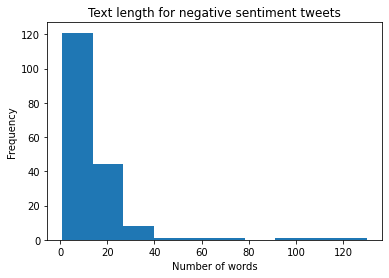

In [ ]:
negative_tweet_len = pd.Series([len(tweet.split()) for tweet 
                                in df_sentiment[df_sentiment['vader_sentiment_score'] == 'Negative']['comment_text']])

print(negative_tweet_len.describe())
plt.title("Text length for negative sentiment tweets")
plt.ylabel("Frequency")
plt.xlabel("Number of words")
plt.hist(negative_tweet_len)

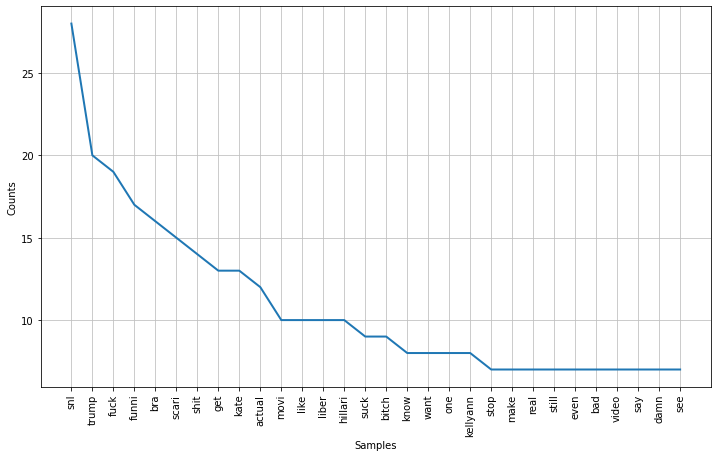

Displaying 25 of 28 matches:
                                      snl trend view wtf anyon know orwellian a
 eye killer moment bad kate like peni snl sad watch im think fuck would much be
 bounc like babi mom funni noon watch snl anymor reli news magazin promot adver
lywood either rape cover rapist decad snl make fun broad see woman snl ridicul 
st decad snl make fun broad see woman snl ridicul expo attack donat correct pol
 hell video get million view day know snl bad track record turn sketch movi wan
hahahaha lost kellyann still frighten snl gay nbc cover fuck sexual predat like
 sort close hell gay liber propaganda snl suck bad fuck snl liber comment view 
ay liber propaganda snl suck bad fuck snl liber comment view call bullshit blac
 dumb play new round polit shit fling snl cnn comedi make funni bottom barrel t
iew kellyann must glutton punish fuck snl sure suck nowaday yup bitch scari tha
 part ya think michigan wisconsin low snl reaaaal low lol pictur conway true ch
care clown 

In [ ]:
df_negative_tweets = df_sentiment[df_sentiment['vader_sentiment_score'] == 'Negative']['cleaned_comment_text']

tokenized_sent = tokenizeAllSent(df_negative_tweets)

fdist = nltk.FreqDist(tokenized_sent)
plt.figure(figsize=(12,7))
fdist.plot(30)
# fdist.most_common(30)

text = nltk.Text(tokenized_sent)
text.concordance('snl')

# Model building with SVM
1. Data splitting to training and testing model
2. Vectorizing the data
3. Create linear SVM
4. Test the model

In [ ]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(df_sentiment['cleaned_comment_text'], 
                                                    df_sentiment['vader_sentiment_score'], 
                                                    test_size=0.2,
                                                    random_state=25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train_dataset = pd.DataFrame({
    'comment_text' : X_train,
    'vader_sentiment_score' : y_train
})

print("Training dataset sentiment distribution\n",train_dataset['vader_sentiment_score'].value_counts(), end='\n')
print("Training dataset head\n", train_dataset.head(), end='\n\n==================================\n')

test_dataset = pd.DataFrame({
    'comment_text' : X_test,
    'vader_sentiment_score' : y_test
})

print("Test dataset sentiment distribution\n",test_dataset['vader_sentiment_score'].value_counts())
print("Test dataset head\n", test_dataset.head())

(631,) (158,) (631,) (158,)
Training dataset sentiment distribution
 Positive    328
Neutral     160
Negative    143
Name: vader_sentiment_score, dtype: int64
Training dataset head
                         comment_text vader_sentiment_score
497              weird find kind hot              Negative
246          kellywis time halloween              Negative
114  go snl classic perfect pennywis              Positive
486                           rachel               Neutral
543              guy seen movi accur               Neutral

Test dataset sentiment distribution
 Positive    80
Neutral     42
Negative    36
Name: vader_sentiment_score, dtype: int64
Test dataset head
                                           comment_text vader_sentiment_score
473                              kate mckinnon goddess               Neutral
531                                          well made               Neutral
103  jesu fuck much terrifi pennywis voic flawless ...              Negative
663  hilari 

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC())])

tuned_parameters = {
    'vect__ngram_range': [(1, 2), (1, 3), (1, 4)],
    'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__tol': [1, 1e-1, 1e-2, 1e-3]
}

clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', LinearSVC())]),
             param_grid={'clf__tol': [1, 0.1, 0.01, 0.001],
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 2), (1, 3), (1, 4)]})

# Model evaluation
1. Confusion matrix
2. Accuracy, precision, recall, f1 score

In [ ]:
print(classification_report(y_test, clf.predict(X_test), digits=4))
print(accuracy_score(y_test, clf.predict(X_test)))
print(confusion_matrix(y_test, clf.predict(X_test)))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

              precision    recall  f1-score   support

    Negative     0.6250    0.4167    0.5000        36
     Neutral     0.5510    0.6429    0.5934        42
    Positive     0.7294    0.7750    0.7515        80

    accuracy                         0.6582       158
   macro avg     0.6351    0.6115    0.6150       158
weighted avg     0.6582    0.6582    0.6522       158

0.6582278481012658
[[15  9 12]
 [ 4 27 11]
 [ 5 13 62]]
Best Score:  0.6798115079365079
Best Params:  {'clf__tol': 0.1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
